<a href="https://colab.research.google.com/github/PisanoRaffaele/Lab_AI/blob/main/QuickDrawCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preambolo**


##Librerie

In [1]:
!pip3 install wget
!pip install tensorrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorrt
import wget
import os
import numpy
import matplotlib.pyplot as pyplot # for visualization of dataset
import random
from types import SimpleNamespace
from pathlib import Path


# PyTorch Lightning
import torch
import torch.nn as nn

try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default.
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision import transforms
from torchvision import datasets


## path modelli e seed

In [3]:
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/"

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

Impostare il seed su PyTorch significa stabilire un valore iniziale per il generatore di numeri casuali. Questo consente di ottenere risultati riproducibili durante l'esecuzione di codice che coinvolge operazioni casuali, come l'inizializzazione dei pesi di un modello o la suddivisione di un dataset in training e test set.

In [4]:
def set_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    pl.seed_everything(seed)

set_seed(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [5]:
# garantisce il determinismo delle operazioni eseguite sulla GPU (se disponibile) in modo da ottenere risultati riproducibili.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

## Dataset

###download

In [6]:
dataset_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"

categories = ["airplane", "car", "apple", "bee", "belt", "bench", "bicycle", "binoculars", "bird", "blackberry", "blueberry", "book",
              "boomerang", "bottlecap","bowtie", "bracelet", "brain", "compass", "computer", "cookie", "cooler", "couch", "cow", "crab",
              "crayon", "crocodile", "crown", "cup", "diamond", "dishwasher"
]
#birthday cake

for category in categories:
  if not os.path.exists(str(category) + ".npy"):
    category_url = dataset_url + str(category) + ".npy"

    wget.download(url = category_url, out = "")
  else:
    print(category + " dataset already downloaded")

airplane dataset already downloaded
car dataset already downloaded
apple dataset already downloaded
bee dataset already downloaded
belt dataset already downloaded
bench dataset already downloaded
bicycle dataset already downloaded
binoculars dataset already downloaded
bird dataset already downloaded
blackberry dataset already downloaded
blueberry dataset already downloaded
book dataset already downloaded
boomerang dataset already downloaded
bottlecap dataset already downloaded
bowtie dataset already downloaded
bracelet dataset already downloaded
brain dataset already downloaded
compass dataset already downloaded
computer dataset already downloaded
cookie dataset already downloaded
cooler dataset already downloaded
couch dataset already downloaded
cow dataset already downloaded
crab dataset already downloaded
crayon dataset already downloaded
crocodile dataset already downloaded
crown dataset already downloaded
cup dataset already downloaded
diamond dataset already downloaded
dishwasher

"https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/"

In [7]:
classesDictonary = {}

for category in categories:
  value = numpy.load(str(category) + ".npy", allow_pickle=True)
  campione = random.randint(0, 90000)
  value = value[campione : campione + 3000]
  classesDictonary[category] = value

Il codice modifica i valori nel dizionario classesDictonary generando una matrice con due colonne per ogni valore nel dizionario. La prima colonna contiene i valori originali convertiti in float32, mentre la seconda colonna contiene zeri nella prima iterazione e il valore dell'indice i moltiplicato per numpy.ones(len(value)) nelle iterazioni successive.

###formattazzione

In [8]:
for i, (key, value) in enumerate(classesDictonary.items()):
  value = value.astype("float32")

  if i == 0:
    classesDictonary[key] = numpy.c_[value, numpy.zeros(len(value))]

  else:
    classesDictonary[key] = numpy.c_[value, i * numpy.ones(len(value))]


Creating the training dataset, reshape and normalize it. trainX are the input features for treaning

###training set

In [9]:
dataDictonary = {}
trainData = []
data_i = []
trainingSamples = 1200

for key, value in classesDictonary.items():
  numpy.random.shuffle(value)
  trainData.append(value[:trainingSamples])
  data_i = []
  data_i.append(value[:trainingSamples])

  numpyData_i = numpy.concatenate(data_i)

  Xi = numpyData_i[:, :784]

  Xi = Xi.reshape(Xi.shape[0], 28, 28, 1).astype("float32")

  Xi = (Xi - 127.5) / 127.5

  dataDictonary[key] = Xi

numpyData = numpy.concatenate(trainData) # Le  immagini vengono concatenate lungo l'asse 0 creando così un array bidimensionale

trainX = numpyData[:, :784] # vengono estratte le prime 784 celle (28x28) (corrispondenti ai pixel delle immagini) e assegnate a trainX

trainY = numpyData[:, -1].astype("int") # viene estratta l'ultima colonna (corrispondente alle etichette delle immagini) e assegnata a trainY.

trainX = trainX.reshape(trainX.shape[0], 1, 28, 28).astype("float32")  #reshape in im 28x28

trainX = (trainX - 127.5) / 127.5 #normalization it (to [0,1])

Il codice visualizza alcune immagini per verificare se il dataset è stato caricato correttamente.

###test set

In [10]:
testSamples = 300
testData = []

for key, value in classesDictonary.items():
    testData.append(value[trainingSamples:trainingSamples+testSamples])

for i in range(len(testData)):
    numpy.random.shuffle(testData[i])

numpyTestData = numpy.concatenate(testData)

testX = numpyTestData[:, :784]
testY = numpyTestData[:, -1].astype("int")

testX = testX.reshape(testX.shape[0], 1, 28, 28).astype("float32")
testX = (testX - 127.5) / 127.5

###validation set

In [11]:
valSamples = 1200
valData = []

for key, value in classesDictonary.items():
    valData.append(value[trainingSamples + testSamples : trainingSamples + testSamples + valSamples])

for i in range(len(valData)):
    numpy.random.shuffle(valData[i])

numpyvalData = numpy.concatenate(valData)

valX = numpyvalData[:, :784]
valY = numpyvalData[:, -1].astype("int")

valX = valX.reshape(valX.shape[0],1, 28, 28).astype("float32")
valX = (valX - 127.5) / 127.5

###visualize

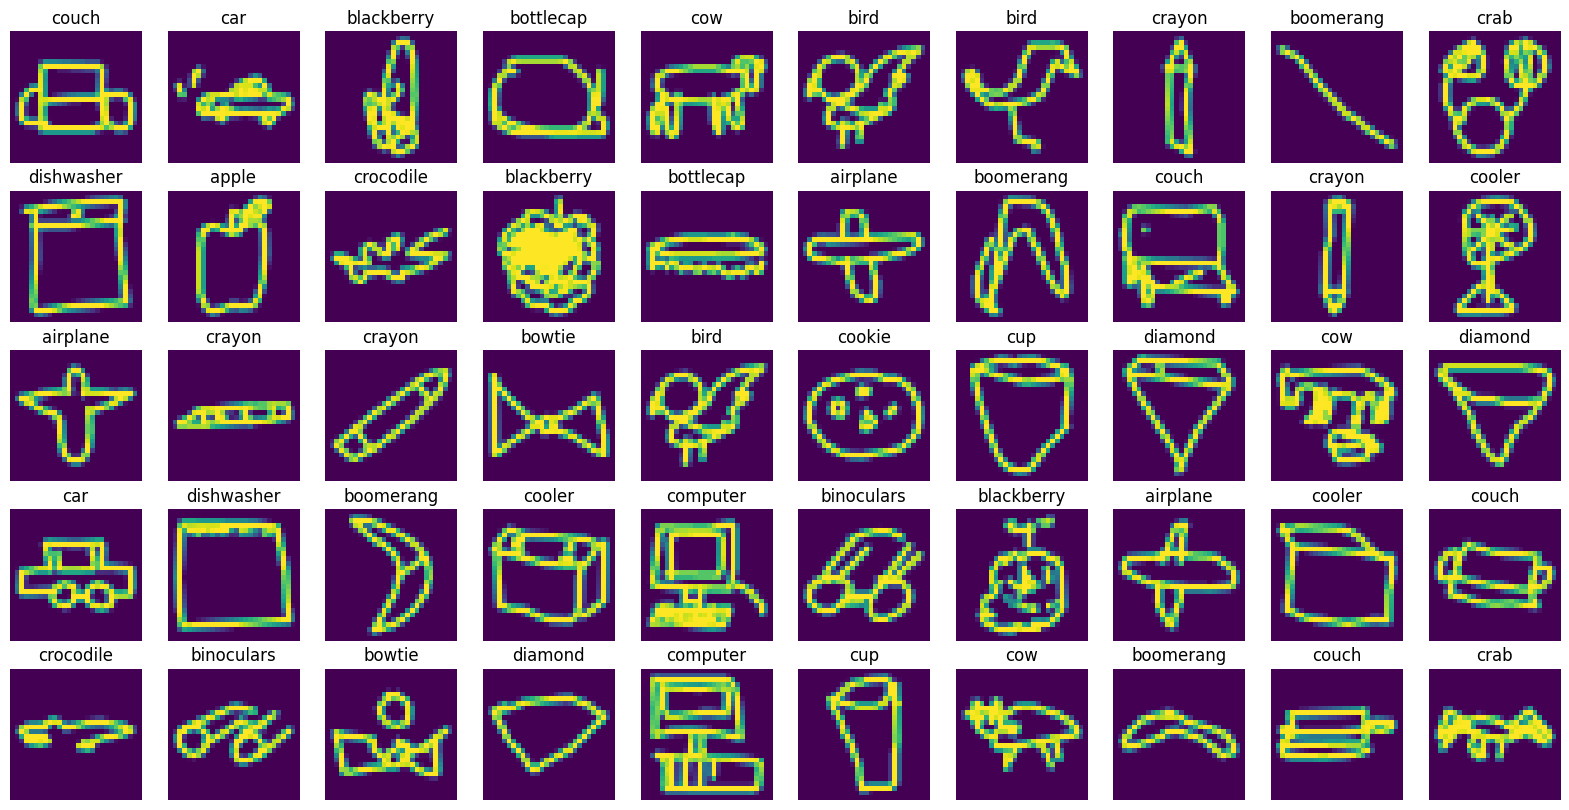

In [12]:
def visualTrainingSet(x, y):
	figure, axes = pyplot.subplots(5, 10, figsize=(20, 10)) #numero di cose da visualizzare

	for label in range(0, 50):

		randomLabel = numpy.random.randint(0, len(x) - 1)

		image = x[randomLabel].reshape((28, 28))
		title = categories[y[randomLabel]]

		xCordinate = label // 10

		yCordinate = label % 10

		axes[xCordinate, yCordinate].set_title(title)
		axes[xCordinate, yCordinate].imshow(image)
		axes[xCordinate, yCordinate].axis('off')

	pyplot.show()

visualTrainingSet(trainX, trainY)
#visualTrainingSet(testX, testY)
#visualTrainingSet(valX, valY)

###SetsCreation

In [13]:
class CustomDataset(data.Dataset):
    def __init__(self, input_tensors, output_tensors):
        self.input_tensors = input_tensors
        self.output_tensors = output_tensors

    def __len__(self):
        return len(self.input_tensors)

    def __getitem__(self, index):
        input_tensor = self.input_tensors[index]
        output_tensor = self.output_tensors[index]
        # Applica eventuali trasformazioni o manipolazioni all'input e all'output
        modified_input = input_tensor
        modified_output = output_tensor
        return modified_input, modified_output

In [14]:
trainX_tensor = torch.from_numpy(trainX)
trainY_tensor = torch.from_numpy(trainY)

testX_tensor = torch.from_numpy(testX)
testY_tensor = torch.from_numpy(testY)

valX_tensor = torch.from_numpy(valX)
valY_tensor = torch.from_numpy(valY)

trainX_tensor = trainX_tensor.to(device)
trainY_tensor = trainY_tensor.to(device)

testX_tensor = testX_tensor.to(device)
testY_tensor = testY_tensor.to(device)

valX_tensor = valX_tensor.to(device)
valY_tensor = valY_tensor.to(device)

train_set = CustomDataset(trainX_tensor, trainY_tensor)
test_set = CustomDataset(testX_tensor, testY_tensor)
val_set = CustomDataset(valX_tensor, valY_tensor)

Creazione dei loader

In [15]:
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

##heatmap

In [16]:
def get_label_heatmap(key, value):

    heatmap = numpy.mean(value, axis=0) # Calcola la media delle immagini filtrate per ottenere una heatmap

    return heatmap

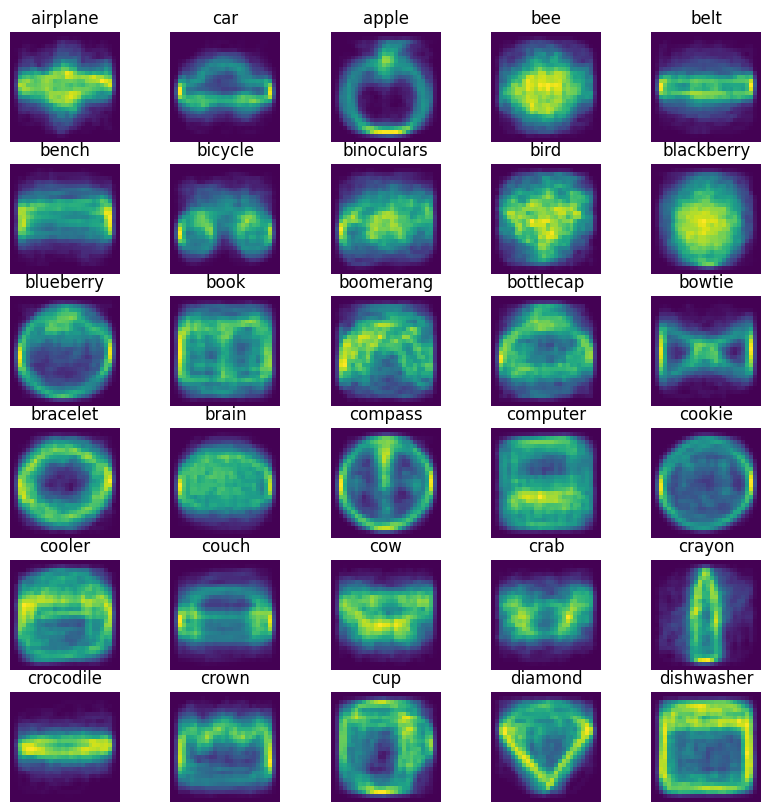

In [17]:
figure, axes = pyplot.subplots(6,5, figsize=(10,10))

x = 0
for key, value in dataDictonary.items():
    # get heatmap
    heatmap = get_label_heatmap(key, value)

    i = x // 5
    j = x % 5
    x+=1

    # plot image
    axes[i,j].set_title(key)
    axes[i,j].imshow(heatmap.reshape(28, 28).squeeze())
    axes[i,j].axis('off')


pyplot.show()

#**Modello**

##Classe

- *model_name:* usato per sfruttare eventualmente differenti modelli di CNN
- *model_hparams:* Iperparametri per il modello
- *optimizer_name:* Il nome dell'ottimizzatore da utilizzare. Attualmente supportati: Adam, SGD.
- *optimizer_hparams:* Iperparametri per l'ottimizzatore (learning rate, weight deacy, ...)

**Ottimizzatori**
> Gli ottimizzatori sono algoritmi utilizzati nell'addestramento delle reti neurali per aggiornare i pesi dei modelli al fine di minimizzare la funzione di perdita durante la fase di apprendimento. L'obiettivo dell'ottimizzazione è trovare i valori ottimali dei pesi del modello. Gli ottimizzatori eseguono il compito di regolare i pesi dei nodi in base al gradiente della funzione di perdita rispetto ai pesi.

>> **SGD**: L'idea di base dell'SGD è aggiornare iterativamente i pesi del modello utilizzando il gradiente calcolato su un batch casuale di dati di addestramento. L'algoritmo procede in cicli di selezione del batch, calcolo del gradiente e aggiornamento dei pesi. Questo processo continua fino a quando non viene raggiunta una condizione di convergenza.

>> **ADAM**: Combina le caratteristiche dell'algoritmo SGD con momenti e un tasso di apprendimento adattivo. Calcola e aggiorna i momenti di primo e secondo ordine dei pesi del modello, utilizzando i gradienti calcolati durante l'addestramento. Questo permette di adattare il tasso di apprendimento per ogni parametro in modo automatico, accelerando la convergenza e gestendo diverse scale dei gradienti.



In [18]:
class QuickDrawModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):

        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()
        # Example input for visualizing the graph in Tensorboard
        self.example_input_array = torch.zeros((1, 1, 28, 28), dtype=torch.float32)

    def forward(self, imgs):
        return self.model(imgs) # Forward function that is run when visualizing the graph

    def configure_optimizers(self):
        # We will support Adam or SGD as optimizers.
        if self.hparams.optimizer_name == "Adam":
            # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
            optimizer = optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
        else:
            assert False, f"Unknown optimizer: \"{self.hparams.optimizer_name}\""

        # We will reduce the learning rate by 0.1 after 100 and 150 epochs
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs) #predizioni
        loss = self.loss_module(preds, labels) #loss
        acc = (preds.argmax(dim=-1) == labels).float().mean() #accuracy

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc)

##Metodi

La callback LearningRateMonitor aggiunge il tasso di apprendimento corrente a TensorBoard, il che aiuta a verificare che il nostro scheduler del tasso di apprendimento funzioni correttamente. La callback ModelCheckpoint consente di personalizzare la procedura di salvataggio dei checkpoint. Ad esempio, è possibile specificare quanti checkpoint mantenere, quando salvare, quale metrica considerare, ecc.

In [19]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import Trainer

Per eventualmente runnare differenti modelli:

In [20]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

Dizionario di funzioni per il modello

In [21]:
fn_by_name = { "tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU }

##Training

In [22]:
import shutil

def train_model(model_name, save_name=None, **kwargs):

    if save_name is None:
        save_name = model_name

    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Specifica la directory in cui salvare i modelli
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",                     # Specifica se utilizzare una GPU o utilizzare solo la CPU
                         devices=1,                                                                          # Specifica il numero di GPU o CPU da utilizzare per l'addestramento
                         max_epochs=180,                                                                     # Specifica il numero massimo di epoche per l'addestramento
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Specifica le callback da utilizzare durante l'addestramento...
                                    LearningRateMonitor("epoch")],                                             # Viene usata ModelCheckpoint: salva il miglior checkpoint in base alla val_acc massima
                         enable_progress_bar=True)                                                             # e LearningRateMonitor per registrare il tasso di apprendimento ad ogni epoca.
    trainer.logger._log_graph = True                                                                         # viene generato il grafico di computazione nel tensorboard.
    trainer.logger._default_hp_metric = None


    # Check whether pretrained model exists. If yes, load it and skip training
    versionfolderList = Path(os.path.join(CHECKPOINT_PATH, save_name, "lightning_logs/")).rglob("version_*")

    found = False;

    for versionfolder in versionfolderList:
        CHECKPOINT_PATH_FILE = os.path.join(f"{versionfolder}/checkpoints/")
        checkpoint_files = list(Path(CHECKPOINT_PATH_FILE).rglob("finished.txt"))
        if (len(checkpoint_files) != 0):
            found = True;
            break;
        else:
            print(f"\nRemoving {versionfolder}... (old model not valid: incomplete training)\n")
            shutil.rmtree(versionfolder)

    if (found):
        pretrained_filename = list(Path(CHECKPOINT_PATH_FILE).rglob("*.ckpt"))[0]
    else:
        pretrained_filename = ""
        print("There is pretrained model: " + str(os.path.isfile(pretrained_filename)))

    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = QuickDrawModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        model = QuickDrawModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = QuickDrawModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result



##Inception Module


inception_block.svg

In [23]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

## GoogleNet

In [24]:
#!
class GoogleNet(nn.Module):

    def __init__(self, num_classes=3, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

model_dict["GoogleNet"] = GoogleNet

##Results

In [ ]:
NomeModello="GoogleNet30classes"

googlenet_model, googlenet_results = train_model(model_name="GoogleNet",
                                                 save_name=NomeModello,
                                                 model_hparams={"num_classes": 30,
                                                                "act_fn_name": "relu"},
                                                 optimizer_name="Adam",
                                                 optimizer_hparams={"lr": 1e-3,
                                                                    "weight_decay": 1e-4})

directory = os.path.join(CHECKPOINT_PATH, NomeModello, "lightning_logs/version_0/checkpoints")

percorso_file = os.path.join(directory, "finished.txt")

with open(percorso_file, "w") as file:
    file.write(".")

dir_tensorboard = os.path.join(CHECKPOINT_PATH, NomeModello, "lightning_logs/version_0")
print("GoogleNet Results", googlenet_results)
# Load tensorboard extension
%load_ext tensorboard

# Opens tensorboard in notebook.
%tensorboard --logdir ../saved_models/GoogleNet3classes/lightning_logs/version_0/

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


There is pretrained model: False


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


#2nd

In [ ]:
params = googlenet_model.state_dict()
print("Learning rate:", params['lr'])
print("Dimensione del batch:", params['batch_size'])

In [ ]:
googlenet_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        # Calcola le predizioni del modello
        outputs = googlenet_model(images)
        _, predicted = torch.max(outputs, 1)

        # Trova gli indici dei campioni classificati in modo errato
        incorrect_samples = torch.nonzero(predicted != labels).squeeze()

        # Visualizza una griglia di campioni classificati in modo errato
        num_samples = min(25, len(incorrect_samples))
        fig, axs = pyplot.subplots(5, 5, figsize=(10, 10))
        for i in range(num_samples):
            image = images[incorrect_samples[i]].permute(1, 2, 0)
            label = labels[incorrect_samples[i]].item()
            predicted_label = predicted[incorrect_samples[i]].item()
            axs[i // 5, i % 5].imshow(image)
            axs[i // 5, i % 5].set_title(f"True: {label}, Predicted: {predicted_label}")
            axs[i // 5, i % 5].axis("off")
        pyplot.tight_layout()
        pyplot.show()

        break